In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
# creating a dataframe from the csv file
df = pd.DataFrame(pd.read_csv('./CSI_Preprocessing/output/zero4_outputs.csv'))
df = df.drop([df.columns[0]], axis='columns') 
df = df.iloc[:,:-3]
df.reset_index(drop=True, inplace=True)
  
# unit='s' to convert it into epoch time
df['Time'] = pd.to_datetime(df['Time'])
  
date_time = df['Time'].dt.strftime('%S')


# checking our dataframe once again
df.head()

,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58,Subcar_59,Subcar_60,Subcar_61
0,1970-01-01 00:00:01.641598541,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079,402.951610,372.625818,343.914233
1,1970-01-01 00:00:01.641598542,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,367.766230,339.484904,339.087009,343.083080,343.739727,346.943799,351.039884,350.000000,353.509547,361.763735
2,1970-01-01 00:00:01.641598543,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791,315.483756,278.195974,245.790561
3,1970-01-01 00:00:01.641598544,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,459.243944,413.706418,406.503383,392.998728,389.802514,381.072172,390.508643,384.002604,387.497097,393.782935
4,1970-01-01 00:00:01.641598545,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355,670.391677,646.208945,616.507096


In [5]:
df.loc[0, 'Time']

Timestamp('1970-01-01 00:00:01.641598541')

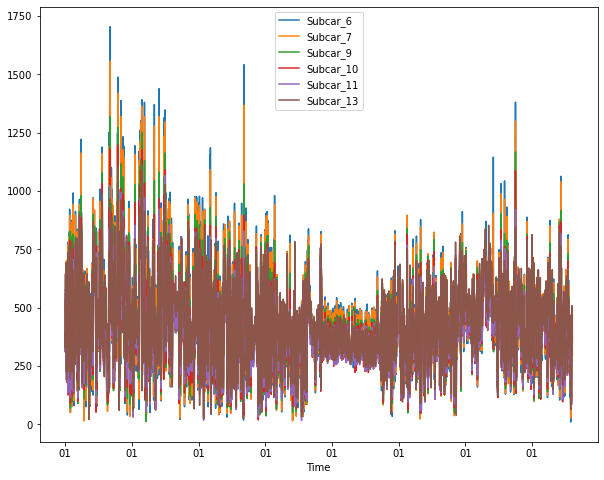

In [6]:
plot_cols = ['Subcar_6', 'Subcar_7','Subcar_9','Subcar_10', 'Subcar_11', 'Subcar_13']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)

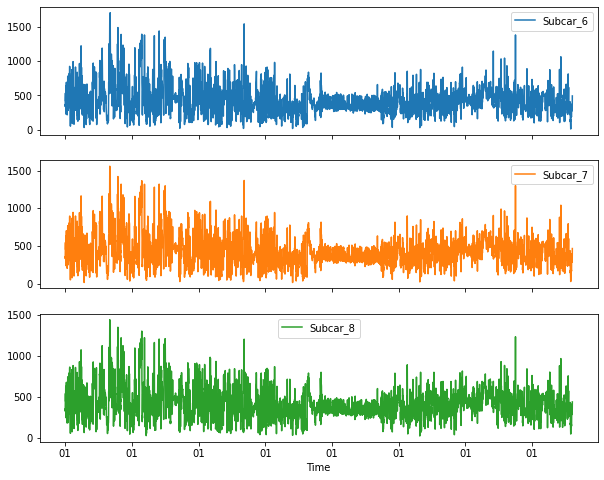

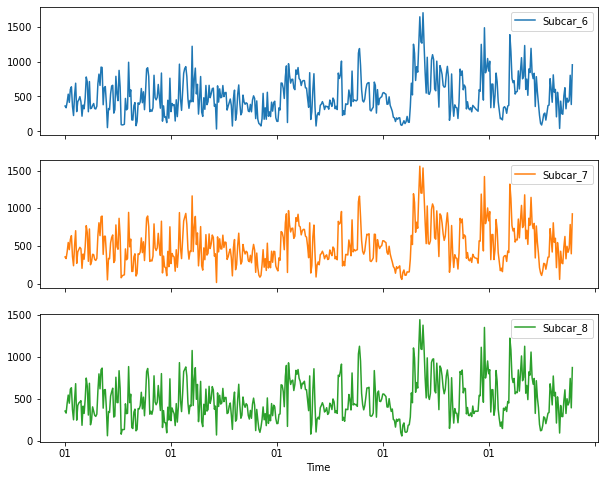

In [7]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)